# Generacion de EDA para la base de datos


--- Información del dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280000 entries, 0 to 1279999
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   ch1     1280000 non-null  float64
 1   ch2     1280000 non-null  float64
 2   ch3     1280000 non-null  float64
 3   ch4     1280000 non-null  float64
dtypes: float64(4)
memory usage: 39.1 MB
None
         count      mean       std       min       25%       50%       75%  \
ch1  1280000.0  0.000639  0.082504 -1.723411 -0.015018  0.000368  0.015739   
ch2  1280000.0 -0.000337  0.062552 -4.466378 -0.016782 -0.000524  0.015001   
ch3  1280000.0  0.000538  0.058581 -0.492958 -0.008232 -0.000223  0.007948   
ch4  1280000.0  0.000001  0.016425 -0.505413 -0.003395 -0.000054  0.003318   

          max  
ch1  8.456798  
ch2  1.451840  
ch3  7.215951  
ch4  0.339045  


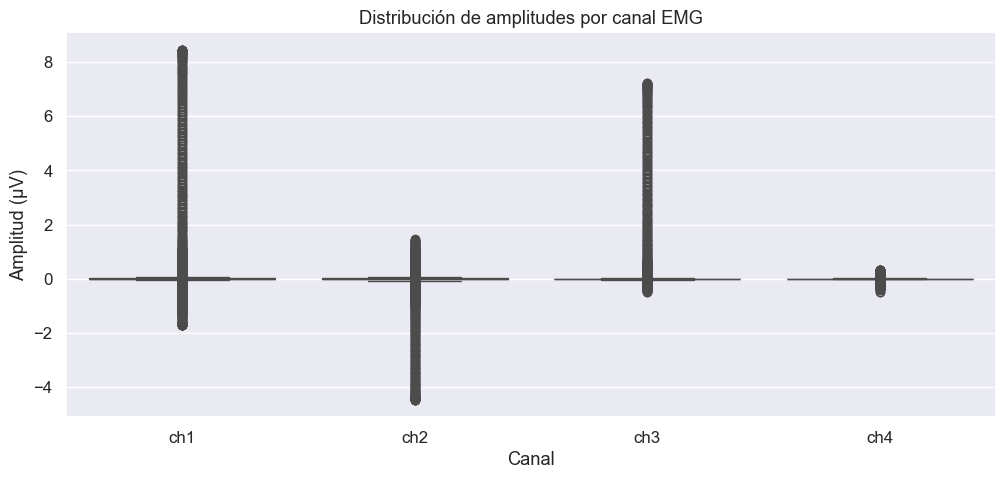

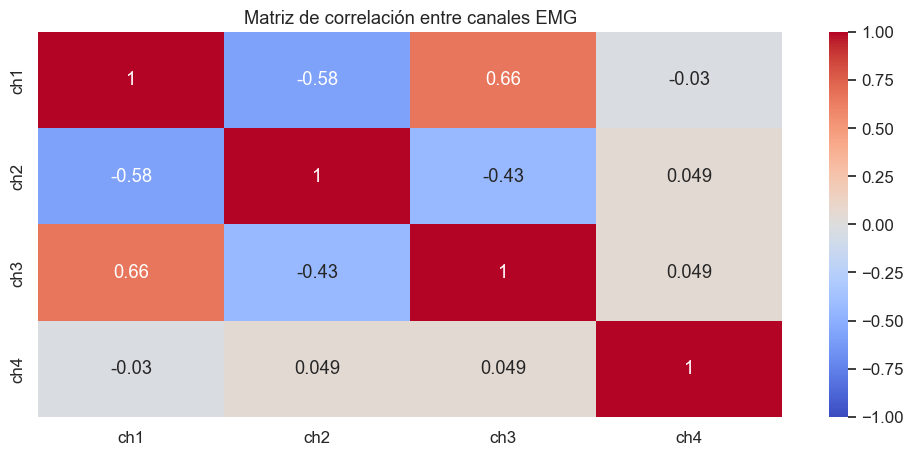

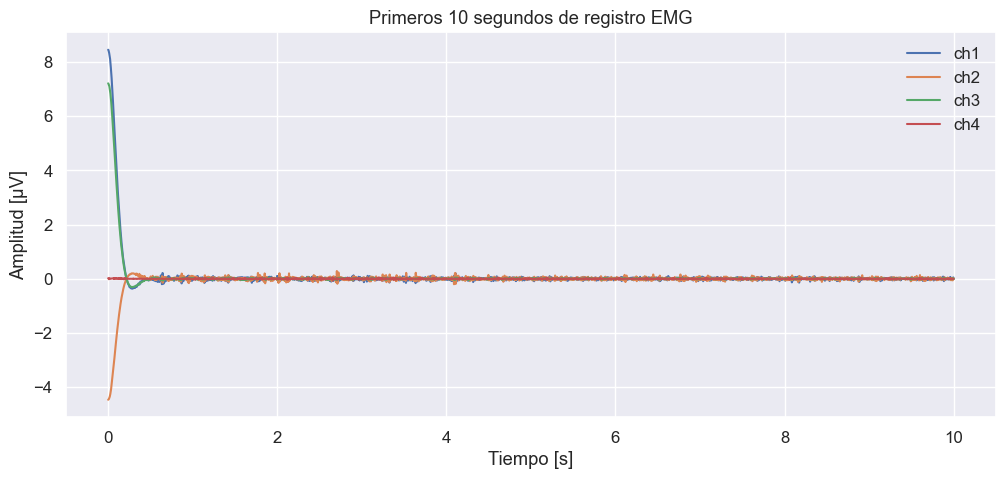

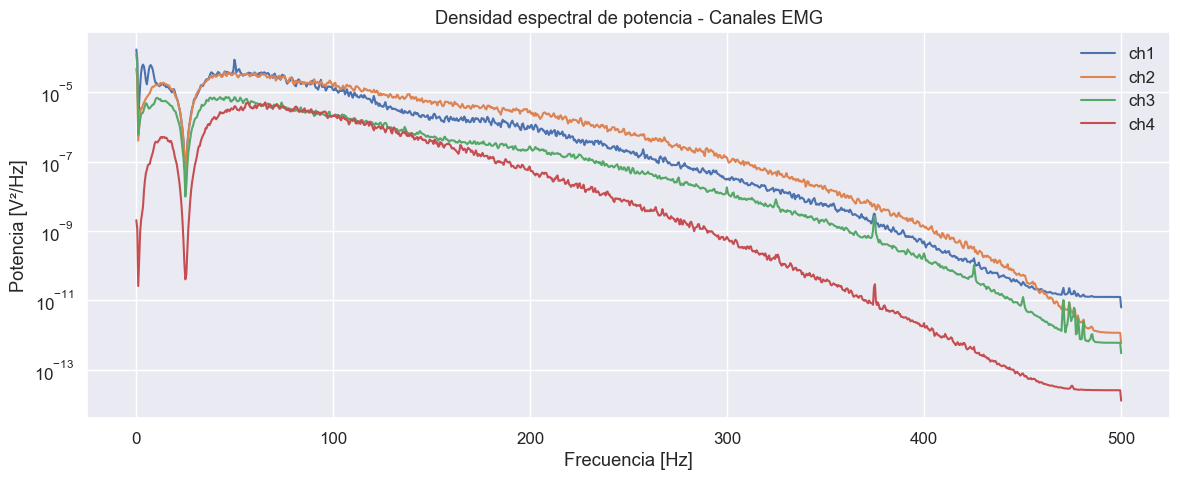

In [11]:
# ============================================
# 📊 EDA para señales EMG sin encabezado (4 canales)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch

# -------------------------------
# 1️⃣ CARGA DE DATOS
# -------------------------------

# Carga del CSV sin encabezado
df = pd.read_csv("C:/Users/DAVID/Desktop/INTRO A SEÑALES/proyecto/ckwc76xr2z-2/sEMG-dataset/filtered/csv/1_filtered.csv", header=None)

# Asignar nombres de columnas
df.columns = ['ch1', 'ch2', 'ch3', 'ch4']

# Mostrar información básica
print("\n--- Información del dataset ---")
print(df.info())
print(df.describe().T)

# -------------------------------
# 2️⃣ DISTRIBUCIÓN DE AMPLITUDES
# -------------------------------

plt.style.use('seaborn-v0_8-darkgrid')
sns.set(font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 5)

df_melt = df.melt(value_vars=['ch1', 'ch2', 'ch3', 'ch4'],
                  var_name='Canal', value_name='Amplitud (µV)')
sns.boxplot(data=df_melt, x='Canal', y='Amplitud (µV)')
plt.title('Distribución de amplitudes por canal EMG')
plt.show()

# -------------------------------
# 3️⃣ CORRELACIÓN ENTRE CANALES
# -------------------------------

corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de correlación entre canales EMG')
plt.show()

# -------------------------------
# 4️⃣ VISUALIZACIÓN TEMPORAL (primeros 10 segundos)
# -------------------------------

# Frecuencia de muestreo aproximada para BIOPAC MP36
fs = 1000  # Hz
t = np.arange(len(df)) / fs

# Graficar los primeros 10 segundos
duracion = 10 * fs
plt.figure(figsize=(12, 5))
for c in ['ch1', 'ch2', 'ch3', 'ch4']:
    plt.plot(t[:duracion], df[c][:duracion], label=c)
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [µV]')
plt.title('Primeros 10 segundos de registro EMG')
plt.legend()
plt.show()

# -------------------------------
# 5️⃣ ESPECTRO DE POTENCIA (Welch)
# -------------------------------
# Protecciones para evitar KeyError por clave tipo tuple o por canales faltantes,
# y para asegurar nperseg <= len(señal)
nperseg = min(2048, len(df))
plt.figure(figsize=(12, 5))

for ch in ['ch1', 'ch2', 'ch3', 'ch4']:
    # Verificar que la columna exista y acceder con .loc (evita ambigüedades)
    if ch not in df.columns:
        print(f"Advertencia: canal '{ch}' no existe en el DataFrame. Columnas disponibles: {list(df.columns)}")
        continue

    sig = df.loc[:, ch].values  # uso explícito de .loc para evitar key tuple issues

    # Comprobar longitud mínima para el cálculo de Welch
    if sig.size < 2:
        print(f"Advertencia: señal del canal '{ch}' demasiado corta ({sig.size} muestras). Se omite.")
        continue

    f, Pxx = welch(sig, fs=fs, nperseg=nperseg)
    plt.semilogy(f, Pxx, label=ch)

plt.title('Densidad espectral de potencia - Canales EMG')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Potencia [V²/Hz]')
plt.legend()
plt.tight_layout()
plt.show()